Normalization checks (should be ~1):
Case 1: ∫f_D1 dσ = 0.9999999999999998 ∫f_A1 dσ = 0.9999999999999998
Case 2: ∫f_D2 dσ = 0.9999999999999999 ∫f_A2 dσ = 0.9999999999999998
Case 3: ∫f_D3 dσ = 1.0 ∫f_A3 dσ = 1.0
Case 1: G1 = 8.881881e-21 s, J1 = 1.853259e-22 J, 9.329520e+00 cm^-1, 2.796920e+11 Hz
Case 2: G2 = 2.506151e-16 s, J2 = 1.103278e-24 J, 5.554030e-02 cm^-1, 1.665056e+09 Hz
Case 3: G3 = 8.695873e-14 s, J3 = 5.922866e-26 J, 2.981640e-03 cm^-1, 8.938732e+07 Hz


C:\Users\Jacob\AppData\Local\Temp\ipykernel_520\1929404644.py:43: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return simps(y, x)


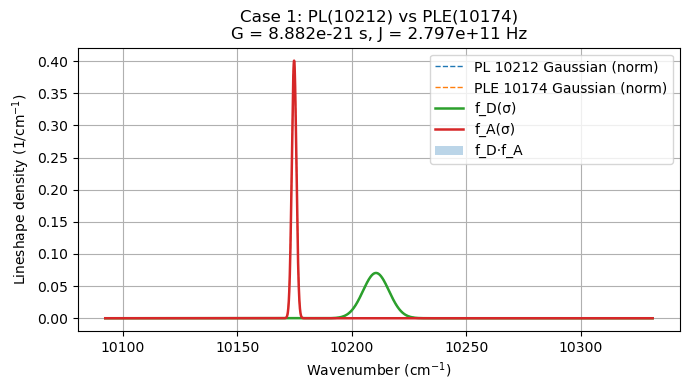

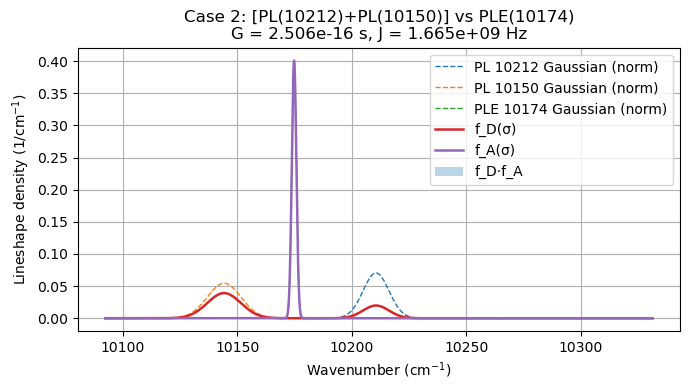

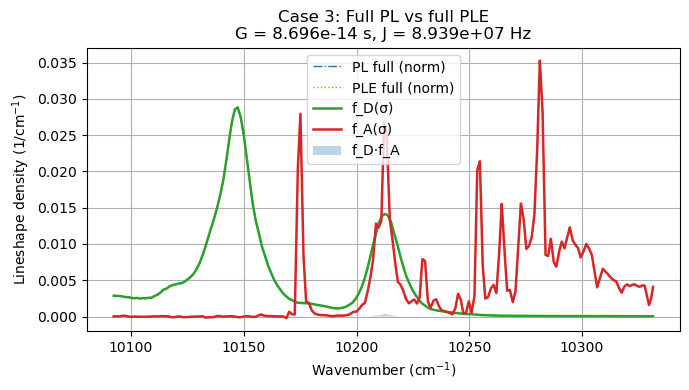

Saved results to: C:\Users\Jacob\Dropbox\Career_and_Education\Grad_School\Research (DB)\Thesis\YbYb cluster\data\overlap_J_analysis_cases.csv


In [39]:
# One-sentence description: Compute three spectral overlap integrals G (s) and couplings J (J, Hz)
# from PL/PLE, using low-res PL as the full donor lineshape and high-res PL for Gaussian peak fits.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.constants import c, hbar, h, pi

# ------------------------------------------------------------
# USER INPUTS
# ------------------------------------------------------------
# High-resolution PL (partial or focused range containing relevant peaks)
path_pl_hi   = r"C:\Users\Jacob\Dropbox\Career_and_Education\Grad_School\Research (DB)\Thesis\YbYb cluster\data\Yb_PL.csv"

# Low-resolution full-range PL (all radiative branches from same excited Yb state)
path_pl_low = r"C:\Users\Jacob\Dropbox\Career_and_Education\Grad_School\Research (DB)\Thesis\YbYb cluster\data\Yb_PL_lowres.csv"

# High-resolution PLE (Er; assumed full range for acceptor)
path_ple     = r"C:\Users\Jacob\Dropbox\Career_and_Education\Grad_School\Research (DB)\Thesis\YbYb cluster\data\Er_PLE.csv"

# Peak windows in cm^-1 for fits
pl_10212_range  = (10180, 10240)   # Yb PL main branch
pl_10150_range  = (10100, 10180)   # Yb PL secondary branch
ple_10174_range = (10160, 10190)   # Er PLE branch

# Experimental ET rate and degeneracies
W_exp = 3.15e4   # s^-1
g_d   = 6        # donor degeneracy (Yb 2F5/2)
g_a   = 12       # acceptor degeneracy (Er 4I11/2)

# Output CSV
output_path = r"C:\Users\Jacob\Dropbox\Career_and_Education\Grad_School\Research (DB)\Thesis\YbYb cluster\data\overlap_J_analysis_cases.csv"

# ------------------------------------------------------------
# HELPER FUNCTIONS
# ------------------------------------------------------------
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2.0 * sigma**2))

def integral(x, y):
    return simps(y, x)

def fit_gaussian_window(x, y, r):
    mask = (x >= r[0]) & (x <= r[1])
    xw, yw = x[mask], y[mask]
    if xw.size < 5 or np.all(yw <= 0):
        raise ValueError(f"Insufficient or nonpositive data in range {r}")
    A0 = yw.max()
    mu0 = xw[np.argmax(yw)]
    sigma0 = (r[1] - r[0]) / 6.0 if (r[1] > r[0]) else 5.0
    popt, _ = curve_fit(gaussian, xw, yw, p0=[A0, mu0, sigma0])
    return popt

def normalize_shape(x, y):
    A = integral(x, y)
    if A <= 0:
        raise ValueError("Non-positive area for normalization.")
    return y / A

def compute_G_seconds(x_cm, f_D, f_A):
    """
    G = (1 / (c*100)) * ∫ f_D(σ) f_A(σ) dσ
    where f_D, f_A are normalized (unit area) line-shapes on wavenumber σ (cm^-1).
    Result: G in seconds.
    """
    G_cm = integral(x_cm, f_D * f_A)        # units: 1/cm^-1
    return G_cm / (c * 100.0)              # → seconds

def compute_J(G_seconds, W_exp, g_d, g_a):
    """
    J^2 = (W_exp * 3 hbar^2 g_d g_a) / (8 pi^3 G)
    Return J (Joules), J_cm (cm^-1), J_Hz (Hz).
    """
    J_sq = (W_exp * 3.0 * hbar**2 * g_d * g_a) / (8.0 * pi**3 * G_seconds)
    J = np.sqrt(J_sq)
    J_cm = J / (h * c * 100.0)
    J_Hz = J / h
    return J, J_cm, J_Hz

def scale_gaussian_to_lowres(x_common, g_raw, pl_low_x, pl_low_y, r):
    """
    Scale a Gaussian so that its area over window r matches the low-res PL area over r.
    """
    # Low-res PL area in r
    mask_low = (pl_low_x >= r[0]) & (pl_low_x <= r[1])
    if not np.any(mask_low):
        raise ValueError(f"No low-res PL data in range {r}")
    A_low = integral(pl_low_x[mask_low], pl_low_y[mask_low])

    # Gaussian area in r, integrated on x_common
    mask_g = (x_common >= r[0]) & (x_common <= r[1])
    if not np.any(mask_g):
        raise ValueError(f"No Gaussian support on x_common in range {r}")
    A_g = integral(x_common[mask_g], g_raw[mask_g])

    if A_g <= 0:
        raise ValueError(f"Gaussian area non-positive in range {r}")
    scale = A_low / A_g
    return g_raw * scale

def plot_case(x, f_D, f_A, G, J_Hz, title, extra_curves=None):
    """
    Plot normalized f_D, f_A, and their true overlap density f_D*f_A as shaded region.
    extra_curves: list of (y, label, style) for context (raw spectra, Gaussians).
    """
    overlap = f_D * f_A

    plt.figure(figsize=(7,4))

    if extra_curves:
        for y, lab, ls in extra_curves:
            plt.plot(x, y, ls, label=lab, linewidth=1.0)

    plt.plot(x, f_D, label="f_D(σ)", linewidth=1.8)
    plt.plot(x, f_A, label="f_A(σ)", linewidth=1.8)

    # True, unscaled overlap density
    plt.fill_between(x, 0, overlap, alpha=0.3, label="f_D·f_A")

    plt.xlabel("Wavenumber (cm$^{-1}$)")
    plt.ylabel("Lineshape density (1/cm$^{-1}$)")
    plt.title(f"{title}\nG = {G:.3e} s, J = {J_Hz:.3e} Hz")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# LOAD DATA
# ------------------------------------------------------------
# Low-res full PL: defines the full donor transition
pl_low_df = pd.read_csv(path_pl_low)
pl_low_x = pl_low_df.iloc[:, 1].to_numpy()
pl_low_y = pl_low_df.iloc[:, 0].to_numpy()
idx = np.argsort(pl_low_x)
pl_low_x, pl_low_y = pl_low_x[idx], pl_low_y[idx]

# High-res PL: for detailed peak shapes
pl_hi_df = pd.read_csv(path_pl_hi)
pl_hi_x = pl_hi_df.iloc[:, 1].to_numpy()
pl_hi_y = pl_hi_df.iloc[:, 0].to_numpy()
idx = np.argsort(pl_hi_x)
pl_hi_x, pl_hi_y = pl_hi_x[idx], pl_hi_y[idx]

# High-res PLE: acceptor spectrum
ple_df = pd.read_csv(path_ple)
ple_x = ple_df.iloc[:, 1].to_numpy()
ple_y = ple_df.iloc[:, 0].to_numpy()
idx = np.argsort(ple_x)
ple_x, ple_y = ple_x[idx], ple_y[idx]

# ------------------------------------------------------------
# COMMON GRID
# ------------------------------------------------------------
x_min = max(pl_low_x.min(), ple_x.min())
x_max = min(pl_low_x.max(), ple_x.max())
if x_max <= x_min:
    raise ValueError("No common PL/PLE spectral region.")
x_common = np.linspace(x_min, x_max, 8000)

# Interpolate low-res PL and PLE on common grid
pl_low_i = np.interp(x_common, pl_low_x, pl_low_y)
ple_i    = np.interp(x_common, ple_x,    ple_y)

# ------------------------------------------------------------
# GAUSSIAN FITS ON HIGH-RES DATA, THEN SCALED TO LOW-RES AREAS
# ------------------------------------------------------------
# Fit Gaussians on high-res PL
popt_pl1 = fit_gaussian_window(pl_hi_x, pl_hi_y, pl_10212_range)   # 10212
popt_pl2 = fit_gaussian_window(pl_hi_x, pl_hi_y, pl_10150_range)   # 10150
pl1_raw = gaussian(x_common, *popt_pl1)
pl2_raw = gaussian(x_common, *popt_pl2)

# Fit Gaussian on high-res PLE
popt_ple = fit_gaussian_window(ple_x, ple_y, ple_10174_range)      # 10174
ple_raw = gaussian(x_common, *popt_ple)

# Scale Gaussians so their areas in their windows match low-res PL / PLE
pl1_scaled = scale_gaussian_to_lowres(x_common, pl1_raw, pl_low_x, pl_low_y, pl_10212_range)
pl2_scaled = scale_gaussian_to_lowres(x_common, pl2_raw, pl_low_x, pl_low_y, pl_10150_range)

# For PLE, use its own full spectrum as reference (same file), so scale to match PLE area in that window
def scale_gaussian_to_ple(x_common, g_raw, ple_x, ple_y, r):
    mask_ple = (ple_x >= r[0]) & (ple_x <= r[1])
    if not np.any(mask_ple):
        raise ValueError(f"No PLE data in range {r}")
    A_ple = integral(ple_x[mask_ple], ple_y[mask_ple])

    mask_g = (x_common >= r[0]) & (x_common <= r[1])
    if not np.any(mask_g):
        raise ValueError(f"No Gaussian support on x_common in range {r}")
    A_g = integral(x_common[mask_g], g_raw[mask_g])

    if A_g <= 0:
        raise ValueError(f"PLE Gaussian area non-positive in range {r}")
    return g_raw * (A_ple / A_g)

ple_scaled = scale_gaussian_to_ple(x_common, ple_raw, ple_x, ple_y, ple_10174_range)

# ------------------------------------------------------------
# CASE 3: Full PL vs full PLE (reference model)
# ------------------------------------------------------------
# Use full low-res PL and full PLE in common region
f_D3 = normalize_shape(x_common, pl_low_i)
f_A3 = normalize_shape(x_common, ple_i)
G3 = compute_G_seconds(x_common, f_D3, f_A3)
J3, J3_cm, J3_Hz = compute_J(G3, W_exp, g_d, g_a)

# ------------------------------------------------------------
# CASE 1: Single-branch model (10212 ↔ 10174)
# ------------------------------------------------------------
I_D1 = pl1_scaled
I_A1 = ple_scaled
f_D1 = normalize_shape(x_common, I_D1)
f_A1 = normalize_shape(x_common, I_A1)
G1 = compute_G_seconds(x_common, f_D1, f_A1)
J1, J1_cm, J1_Hz = compute_J(G1, W_exp, g_d, g_a)

# ------------------------------------------------------------
# CASE 2: Two-branch donor (10212 + 10150) vs 10174
# ------------------------------------------------------------
I_D2 = pl1_scaled + pl2_scaled
I_A2 = ple_scaled
f_D2 = normalize_shape(x_common, I_D2)
f_A2 = normalize_shape(x_common, I_A2)
G2 = compute_G_seconds(x_common, f_D2, f_A2)
J2, J2_cm, J2_Hz = compute_J(G2, W_exp, g_d, g_a)

# ------------------------------------------------------------
# CHECK NORMALIZATION
# ------------------------------------------------------------
print("Normalization checks (should be ~1):")
print("Case 1: ∫f_D1 dσ =", integral(x_common, f_D1), "∫f_A1 dσ =", integral(x_common, f_A1))
print("Case 2: ∫f_D2 dσ =", integral(x_common, f_D2), "∫f_A2 dσ =", integral(x_common, f_A2))
print("Case 3: ∫f_D3 dσ =", integral(x_common, f_D3), "∫f_A3 dσ =", integral(x_common, f_A3))

print(f"Case 1: G1 = {G1:.6e} s, J1 = {J1:.6e} J, {J1_cm:.6e} cm^-1, {J1_Hz:.6e} Hz")
print(f"Case 2: G2 = {G2:.6e} s, J2 = {J2:.6e} J, {J2_cm:.6e} cm^-1, {J2_Hz:.6e} Hz")
print(f"Case 3: G3 = {G3:.6e} s, J3 = {J3:.6e} J, {J3_cm:.6e} cm^-1, {J3_Hz:.6e} Hz")

# ------------------------------------------------------------
# PLOTS WITH TRUE SHADED OVERLAP
# ------------------------------------------------------------

# Case 1: show Gaussians + overlap
plot_case(
    x_common,
    f_D1,
    f_A1,
    G1,
    J1_Hz,
    "Case 1: PL(10212) vs PLE(10174)",
    extra_curves=[
        (normalize_shape(x_common, pl1_scaled), "PL 10212 Gaussian (norm)", "--"),
        (normalize_shape(x_common, ple_scaled), "PLE 10174 Gaussian (norm)", "--"),
    ]
)

# Case 2: two donor Gaussians + one acceptor Gaussian
plot_case(
    x_common,
    f_D2,
    f_A2,
    G2,
    J2_Hz,
    "Case 2: [PL(10212)+PL(10150)] vs PLE(10174)",
    extra_curves=[
        (normalize_shape(x_common, pl1_scaled), "PL 10212 Gaussian (norm)", "--"),
        (normalize_shape(x_common, pl2_scaled), "PL 10150 Gaussian (norm)", "--"),
        (normalize_shape(x_common, ple_scaled), "PLE 10174 Gaussian (norm)", "--"),
    ]
)

# Case 3: full PL vs full PLE (reference)
plot_case(
    x_common,
    f_D3,
    f_A3,
    G3,
    J3_Hz,
    "Case 3: Full PL vs full PLE",
    extra_curves=[
        (normalize_shape(x_common, pl_low_i), "PL full (norm)", "-."),
        (normalize_shape(x_common, ple_i), "PLE full (norm)", ":"),
    ]
)

# ------------------------------------------------------------
# SAVE NUMERIC DATA
# ------------------------------------------------------------
out = pd.DataFrame({
    "wavenumber_cm-1": x_common,
    "f_D1_case1": f_D1,
    "f_A1_case1": f_A1,
    "f_D2_case2": f_D2,
    "f_A2_case2": f_A2,
    "f_D3_case3": f_D3,
    "f_A3_case3": f_A3,
    "overlap_density_case1": f_D1 * f_A1,
    "overlap_density_case2": f_D2 * f_A2,
    "overlap_density_case3": f_D3 * f_A3,
})

with open(output_path, 'w', newline='') as f:
    f.write("# Overlap integrals G (s) and couplings J (J, cm^-1, Hz)\n")
    f.write(f"# Case 1: G1 = {G1:.6e} s, J1 = {J1:.6e} J, {J1_cm:.6e} cm^-1, {J1_Hz:.6e} Hz\n")
    f.write(f"# Case 2: G2 = {G2:.6e} s, J2 = {J2:.6e} J, {J2_cm:.6e} cm^-1, {J2_Hz:.6e} Hz\n")
    f.write(f"# Case 3: G3 = {G3:.6e} s, J3 = {J3:.6e} J, {J3_cm:.6e} cm^-1, {J3_Hz:.6e} Hz\n")
    out.to_csv(f, index=False)

print(f"Saved results to: {output_path}")
